### Install necessary dependencies

In [21]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes

import pandas as pd
import html5lib
import requests
import numpy as np
import matplotlib.pyplot 
import requests # library to handle requests
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Folium installed
Libraries imported.


In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radii):
    
    venues_list=[]
    for name, lat, lng,radius in zip(names, latitudes, longitudes,radii):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
linz_df = pd.read_csv("https://raw.githubusercontent.com/philippmoser/Coursera_Capstone/master/linz_facts.csv")
linz_df.head(16)

,DistrictNr,Name,Population,Area
0,1,Innere-Stadt,25386,279
1,2,Urfahr,24017,427
2,3,Pöstlingberg,4619,858
3,4,St-Magdalena,11990,655
4,5,Dornach-Auhof,7298,683
5,6,Kaplanhof,9914,243
6,7,Franckviertel,6856,121
7,8,Bulgariplatz,16721,260
8,9,Froschberg,11733,453
9,10,Bindermichl-Keferfeld,20303,412


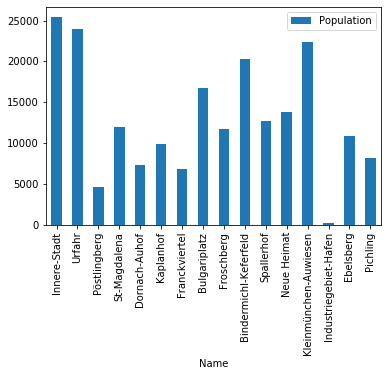

In [25]:
linz_df.plot.bar(x="Name", y="Population", rot=90)

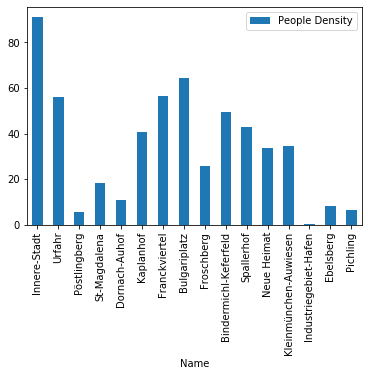

In [26]:
density_df=linz_df
density_df["People Density"]=linz_df["Population"]/linz_df["Area"]
density_df.plot.bar(x="Name", y="People Density", rot=90,)

### include lat and long coordinates to dataframe

In [27]:
linz_df['Latitude']=0.
linz_df['Longitude']=0.

for i in range(0,len(linz_df)):
    
    address = linz_df['Name'][i] + " Linz Austria"

    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    linz_df.at[i,"Latitude"]= latitude
    linz_df.at[i,"Longitude"]= longitude

linz_df.head(16)

,DistrictNr,Name,Population,Area,People Density,Latitude,Longitude
0,1,Innere-Stadt,25386,279,90.989247,48.300024,14.292206
1,2,Urfahr,24017,427,56.245902,48.313812,14.280403
2,3,Pöstlingberg,4619,858,5.383450,48.324191,14.257989
3,4,St-Magdalena,11990,655,18.305344,48.336475,14.300407
4,5,Dornach-Auhof,7298,683,10.685212,48.337840,14.327125
5,6,Kaplanhof,9914,243,40.798354,48.309998,14.306606
6,7,Franckviertel,6856,121,56.661157,48.297239,14.311137
7,8,Bulgariplatz,16721,260,64.311538,48.287761,14.301991
8,9,Froschberg,11733,453,25.900662,48.289447,14.278021
9,10,Bindermichl-Keferfeld,20303,412,49.279126,48.267756,14.286414


In [28]:
# create map of Linz using latitude and longitude values
map_linz = folium.Map(location=[linz_df.at[0,"Latitude"],linz_df.at[0,"Longitude"]], zoom_start=12)

# add markers to map
for lat, lng, name in zip(linz_df['Latitude'], linz_df['Longitude'], linz_df['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_linz)  
    
map_linz

## Get all venues for all Linz Districts

In [29]:
CLIENT_ID = 'M2HI2KQ4AOPJFHIXQLDUQXCRBIJZGZQNXM5BLATTG1JDPCSB' # your Foursquare ID
CLIENT_SECRET = 'IHIBGBPODXJB0MTPHEWNGQ4OJIIE22BEF2HC5OK4OIYDBSOP' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M2HI2KQ4AOPJFHIXQLDUQXCRBIJZGZQNXM5BLATTG1JDPCSB
CLIENT_SECRET:IHIBGBPODXJB0MTPHEWNGQ4OJIIE22BEF2HC5OK4OIYDBSOP


In [30]:
linz_venues = getNearbyVenues(names=linz_df['Name'],
                                   latitudes=linz_df['Latitude'],
                                   longitudes=linz_df['Longitude'],
                                  radii=np.sqrt(linz_df["Area"]*10000/np.pi)
                                  )
linz_venues.groupby('Name').count()
print('There are {} uniques categories.'.format(len(linz_venues['Venue Category'].unique())))

Innere-Stadt
Urfahr
Pöstlingberg
St-Magdalena
Dornach-Auhof
Kaplanhof
Franckviertel
Bulgariplatz
Froschberg
Bindermichl-Keferfeld
Spallerhof
Neue Heimat
Kleinmünchen-Auwiesen
Industriegebiet-Hafen
Ebelsberg
Pichling
There are 117 uniques categories.


In [31]:
venue_counts = pd.DataFrame(columns=["Name","Green","Market","Bar"])
import matplotlib.pyplot as plt

for n in range(0,16):
    bezirk=linz_venues[linz_venues["Name"]==linz_df["Name"][n]]
    green = bezirk[(bezirk["Venue Category"].str.contains("Park")) | (bezirk["Venue Category"].str.contains("Hill")) |
                     (bezirk["Venue Category"].str.contains("Mountain")) | (bezirk["Venue Category"].str.contains("Botanical Garden")) |
                     (bezirk["Venue Category"].str.contains("Zoo"))].shape[0]
    
    market = bezirk[(bezirk["Venue Category"].str.contains("Supermarket")) | (bezirk["Venue Category"].str.contains("Fair")) |
                     (bezirk["Venue Category"].str.contains("Bakery")) | (bezirk["Venue Category"].str.contains("Shop"))].shape[0]
    
    bar = bezirk[(bezirk["Venue Category"] == "Café") | (bezirk["Venue Category"].str.contains("Restaurant")) |
                     (bezirk["Venue Category"].str.contains("Bar")) | (bezirk["Venue Category"].str.contains("Osteria"))].shape[0]
    
    venue_counts = venue_counts.append({'Name': linz_df["Name"][n],
                                          'Green': green,
                                          'Market': market,
                                           'Bar':bar}, ignore_index=True)
    
venue_counts

,Name,Green,Market,Bar
0,Innere-Stadt,1,7,25
1,Urfahr,4,10,31
2,Pöstlingberg,3,0,6
3,St-Magdalena,1,9,8
4,Dornach-Auhof,0,6,7
5,Kaplanhof,0,7,7
6,Franckviertel,0,1,1
7,Bulgariplatz,1,7,10
8,Froschberg,4,9,13
9,Bindermichl-Keferfeld,1,3,3


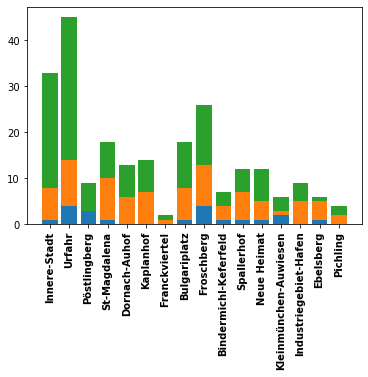

In [32]:
plt.bar(range(1,17),venue_counts["Green"])
plt.bar(range(1,17),venue_counts["Market"],bottom=venue_counts["Green"])
plt.bar(range(1,17),venue_counts["Bar"],bottom=venue_counts["Green"]+venue_counts["Market"])
plt.xticks(range(1,17), venue_counts["Name"], fontweight='bold',rotation=90)

plt.show()
